# C2Q Method 2

In [1]:
import numpy as np
from sympy import init_printing, Matrix, pprint

init_printing()

# Random data function used in experiments
def random_data(n_qubits, magnitude=False, use_complex_data=False, seed=None):
    if seed:
        np.random.seed(seed)

    n_states = 2**n_qubits
    x = np.random.rand(n_states)

    if use_complex_data:
        x = x + (np.random.rand(n_states) * 2j) - 1j
    else:
        x = x * 255

    mag = np.linalg.norm(x)
    x_in = x / mag

    if magnitude:
        return x_in, mag
    else:
        return x_in
    
def partial_measurement(psi_in, bits_to_remove):
    psi_out = np.zeros_like(psi_in)  # Output vector with same length as psi_in

    # Create bitmask from bits_to_remove
    bitmask = sum(2**x for x in bits_to_remove)
    bitmask = ~bitmask  # Negative mask of bitmask

    # Reduce psi_in while preserving indices
    for i, x in enumerate(psi_in):
        i_out = i & bitmask  # index in psi_out to insert value
        psi_out[i_out] += (
            np.abs(x) ** 2
        )  # Add the square of the value in psi (probability)
    psi_out = np.sqrt(psi_out)  # Take sqrt to return to a "statevector"

    return psi_out

# x_in = random_data(n_qubits=2, use_complex_data=False, seed=2)
x_in = [1, 1, 4, 0, 3, 8, 2, 9]
# x_in = partial_measurement(x_in, [1])

Matrix(x_in)

In [2]:
# Format input array properly
x_in = np.array(x_in)

# Calculate number of necessary qubits and states
num_qubits = int(np.ceil(np.log2(len(x_in))))
num_states = np.power(2, num_qubits, dtype=int)

# Pad input array if necessary
if num_states - len(x_in) != 0: 
    print(f'Input length is not power of 2. Padding...')
    x_in = np.pad(x_in, (0, num_states-len(x_in)), 'constant', constant_values=0)
    print(f'New input: {x_in}')

# Normalize input array if necessary
if np.linalg.norm(x_in) != 1:
    print(f'Input is not normalized. Normalizing...')
    x_in = x_in / np.linalg.norm(x_in)
    print(f'New input: {x_in}')

Input is not normalized. Normalizing...
New input: [0.07537784 0.07537784 0.30151134 0.         0.22613351 0.60302269
 0.15075567 0.67840053]


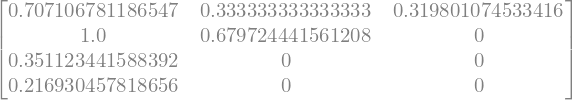

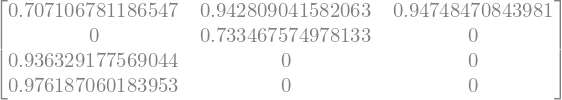

In [3]:
### ============================ ###
###  Calculate input parameters  ###
### ============================ ###

# Generates P matrix as in Eq. 17
# Returns tuple of alpha and beta matrices from P, see Eqs. 18 and 19
def get_ab(x_in):    
    p = x_in
    
    i_max = int(np.ceil(len(x_in)/2))
    j_max = int(np.ceil(np.log2(len(x_in))))
    P = np.zeros((i_max, j_max), dtype=complex)
    alpha = np.zeros((i_max, j_max), dtype=complex)
    beta = np.zeros((i_max, j_max), dtype=complex)
    
    for j in range(j_max):
        x = np.reshape(p, (int(len(p) / 2), 2))
        p = np.linalg.norm(x, axis=1)

        with np.errstate(divide="ignore", invalid="ignore"):
            a, b = np.array(
                [y / m if m > 0 else (1, 0) for y, m in zip(x, p)]
            ).T
            
        
        P[:len(p),j] = p
        alpha[:len(a),j] = a
        beta[:len(b),j] = b
        
    return (alpha, beta)
        
    
alpha, beta = get_ab(x_in)

display(Matrix(alpha), Matrix(beta))

/var/folders/sy/jspx4wmd7sd9lqc7clfzx4jw0000gn/T/ipykernel_60287/1076871810.py:9: RuntimeWarning: invalid value encountered in divide
  theta = 2*np.nan_to_num(np.arctan(beta_mag/alpha_mag), nan=np.pi/2)


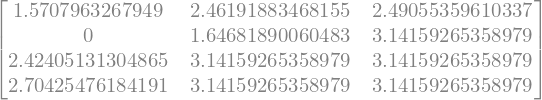

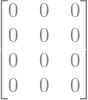

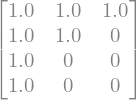

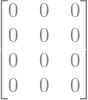

In [4]:
# Returns values of theta, phi, r, and t according to Eq. 20
def get_params(alpha, beta):
    alpha_mag = np.abs(alpha)
    alpha_phase = np.angle(alpha)
    beta_mag = np.abs(beta)
    beta_phase = np.angle(beta)

    with np.errstate(divide='ignore'):
        theta = 2*np.nan_to_num(np.arctan(beta_mag/alpha_mag), nan=np.pi/2)
    phi = beta_phase - alpha_phase
    r = np.sqrt(alpha_mag**2 + beta_mag**2)
    t = beta_phase + alpha_phase

    return theta, phi, r, t

# Returns tuple of theta, phi, r, and t tensors given input data
def input_data(x_in):
    return get_params(alpha, beta)

theta_array, phi_array, r_array, t_array = input_data(x_in)

display(Matrix(theta_array), Matrix(phi_array), Matrix(r_array), Matrix(t_array))

In [5]:
# Basic gates

def Ry(theta):
    return np.matrix(f'{np.cos(theta/2)}, {-np.sin(theta/2)}; {np.sin(theta/2)}, {np.cos(theta/2)}')

def Rz(phi):
    return np.matrix(f'{np.exp(-1j*phi/2)}, {0}; {0}, {np.exp(1j*phi/2)}')

def Uij(theta, phi, r, t):
    #return r * np.exp(1j*t/2) * (Rz(phi) @ Ry(theta))
    return (Rz(phi) @ Ry(theta) @ Rz(-t)) * r
    # return (Rz(phi-t) @ Ry(theta)) * r

In [6]:
# Contruct each Uj in pyramidal structure
Uj_array = []

for j in range(num_qubits):
    n_j = num_qubits - 1 - j
    i_max = 2**(n_j)

    theta_j = theta_array[0:i_max,j]
    phi_j = phi_array[0:i_max,j]
    r_j = r_array[0:i_max,j]
    t_j = t_array[0:i_max,j]
    
    Uj = np.asmatrix(np.zeros((2*i_max, 2*i_max)), dtype=complex)
    for i, (theta, phi, r, t) in enumerate(zip(theta_j, phi_j, r_j, t_j)):
        Uj[2*i:2*i+2, 2*i:2*i+2] = Uij(theta, phi, r, t)

    Uj_array.append(Uj)
    # print(Uj)

In [7]:
# 1 qubit |0> state
zero_state = np.matrix('1;0')

# Create initial quantum state
psi_0 = zero_state
for _ in range(num_qubits-1):
    psi_0 = np.kron(zero_state, psi_0)

In [8]:
# Find matrix for entire circuit
U_block = np.eye(2**num_qubits)
for (n_j, U_j) in enumerate(reversed(Uj_array)):
    U_j_kron = np.kron(U_j, np.eye(2**(num_qubits - 1 - n_j)))
    U_block = U_j_kron @ U_block

# Encode state
psi = U_block @ psi_0

In [9]:
# Helper function for printing matrix in LATEX format
def matrix(M: np.matrix) -> str:
    output = '\\begin{bmatrix}'

    n_cols = 1
    if len(M.shape) == 2:
        _, n_cols = M.shape

    for i, m in enumerate(np.nditer(M)):
        output += f'{m:.03f}'

        if ((i+1) % n_cols) == 0:
            output += '\\\\'
        else:
            output += '&'

    output += '\\end{bmatrix}'

    return output

# Test if matrices are unitary
def is_unitary(M: np.matrix) -> bool:
    M = np.asmatrix(M)

    if len(M.shape) != 2:
        return False;

    n_rows, n_cols = M.shape

    if n_rows != n_cols:
        return False

    M_squared = M @ M.getH()
    M_squared = M_squared.round(3)

    # print(M_squared)

    return np.array_equal(M_squared, np.eye(n_rows))    

In [10]:
# Print important values in LATEX
from IPython.display import Markdown as md

md_str  = f'Input data: ${matrix(x_in)}$, '
md_str += f'Number of qubits: {num_qubits}\n'

md_str += '\n'

md_str += f'Matrix of parameters: \n\n'
md_str += f'$\\theta = {matrix(theta_array)}$, '
md_str += f'$\phi = {matrix(phi_array)}$, '
md_str += f'$t = {matrix(t_array)}$, '

# I don't know how to fix r
md_str += f'$r = {matrix(r_array)}$\n'

md_str += '\n'

md_str += f'Each $U_j$ matrix defined in C2Q Method 2: \n\n'
for j, Uj in enumerate(Uj_array):
    md_str += f'$U_{j} = {matrix(Uj)}$\n'
    md_str += f'(Unitary: {is_unitary(Uj)})\n\n'

md_str += '\n'

md_str += f'The matrix for the circuit overall: '
md_str += f'$\left( U^{{C2Q-2}}\lvert 0 \\rangle^{{\otimes n}} = \\vert \Psi \\rangle \\right)$ \n\n'
md_str += f'$U^{{C2Q-2}} = {matrix(U_block)}$\n'
md_str += f'(Unitary: {is_unitary(U_block)})\n\n'

md_str += '\n'

md_str += f'Final encoded state: \n\n'
md_str += f'$\lvert \Psi \\rangle = {matrix(psi)}$\n'

md_str += '\n'

md_str += f'Is final state correct?: {np.allclose(x_in, np.transpose(psi))}\n'

md(md_str)

Input data: $\begin{bmatrix}0.075\\0.075\\0.302\\0.000\\0.226\\0.603\\0.151\\0.678\\\end{bmatrix}$, Number of qubits: 3

Matrix of parameters: 

$\theta = \begin{bmatrix}1.571&2.462&2.491\\0.000&1.647&3.142\\2.424&3.142&3.142\\2.704&3.142&3.142\\\end{bmatrix}$, $\phi = \begin{bmatrix}0.000&0.000&0.000\\0.000&0.000&0.000\\0.000&0.000&0.000\\0.000&0.000&0.000\\\end{bmatrix}$, $t = \begin{bmatrix}0.000&0.000&0.000\\0.000&0.000&0.000\\0.000&0.000&0.000\\0.000&0.000&0.000\\\end{bmatrix}$, $r = \begin{bmatrix}1.000&1.000&1.000\\1.000&1.000&0.000\\1.000&0.000&0.000\\1.000&0.000&0.000\\\end{bmatrix}$

Each $U_j$ matrix defined in C2Q Method 2: 

$U_0 = \begin{bmatrix}0.707+0.000j&-0.707+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j\\0.707+0.000j&0.707+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j\\0.000+0.000j&0.000+0.000j&1.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j\\0.000+0.000j&0.000+0.000j&0.000+0.000j&1.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j\\0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.351+0.000j&-0.936+0.000j&0.000+0.000j&0.000+0.000j\\0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.936+0.000j&0.351+0.000j&0.000+0.000j&0.000+0.000j\\0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.217+0.000j&-0.976+0.000j\\0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.000+0.000j&0.976+0.000j&0.217+0.000j\\\end{bmatrix}$
(Unitary: True)

$U_1 = \begin{bmatrix}0.333+0.000j&-0.943+0.000j&0.000+0.000j&0.000+0.000j\\0.943+0.000j&0.333+0.000j&0.000+0.000j&0.000+0.000j\\0.000+0.000j&0.000+0.000j&0.680+0.000j&-0.733+0.000j\\0.000+0.000j&0.000+0.000j&0.733+0.000j&0.680+0.000j\\\end{bmatrix}$
(Unitary: True)

$U_2 = \begin{bmatrix}0.320+0.000j&-0.947+0.000j\\0.947+0.000j&0.320+0.000j\\\end{bmatrix}$
(Unitary: True)


The matrix for the circuit overall: $\left( U^{C2Q-2}\lvert 0 \rangle^{\otimes n} = \vert \Psi \rangle \right)$ 

$U^{C2Q-2} = \begin{bmatrix}0.075+0.000j&-0.075+0.000j&-0.213+0.000j&0.213+0.000j&-0.223+0.000j&0.223+0.000j&0.632+0.000j&-0.632+0.000j\\0.075+0.000j&0.075+0.000j&-0.213+0.000j&-0.213+0.000j&-0.223+0.000j&-0.223+0.000j&0.632+0.000j&0.632+0.000j\\0.302+0.000j&0.000+0.000j&0.107+0.000j&0.000+0.000j&-0.893+0.000j&0.000+0.000j&-0.316+0.000j&0.000+0.000j\\0.000+0.000j&0.302+0.000j&0.000+0.000j&0.107+0.000j&0.000+0.000j&-0.893+0.000j&0.000+0.000j&-0.316+0.000j\\0.226+0.000j&-0.603+0.000j&-0.244+0.000j&0.651+0.000j&0.076+0.000j&-0.204+0.000j&-0.082+0.000j&0.220+0.000j\\0.603+0.000j&0.226+0.000j&-0.651+0.000j&-0.244+0.000j&0.204+0.000j&0.076+0.000j&-0.220+0.000j&-0.082+0.000j\\0.151+0.000j&-0.678+0.000j&0.140+0.000j&-0.629+0.000j&0.051+0.000j&-0.229+0.000j&0.047+0.000j&-0.212+0.000j\\0.678+0.000j&0.151+0.000j&0.629+0.000j&0.140+0.000j&0.229+0.000j&0.051+0.000j&0.212+0.000j&0.047+0.000j\\\end{bmatrix}$
(Unitary: True)


Final encoded state: 

$\lvert \Psi \rangle = \begin{bmatrix}0.075+0.000j\\0.075+0.000j\\0.302+0.000j\\0.000+0.000j\\0.226+0.000j\\0.603+0.000j\\0.151+0.000j\\0.678+0.000j\\\end{bmatrix}$

Is final state correct?: True
